# SgrA* Comparison
---
This notebook compares Noisy [1,2] generated movies to the SgrA* data. 

**Note the 'dev' branch of ehtim is needed.**


[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [154]:
import pynoisy
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tqdm.notebook import tqdm
import time as ttime
from ehtim.imaging import starwarps as sw
import ehtim.scattering as so
import ehtim.imaging.dynamical_imaging as di
import sys 
from scipy.ndimage import median_filter
from ipywidgets import interactive, fixed
import ipywidgets as widgets
from pynoisy import eht_functions as ehtf
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [181]:
"""
Function definitions
"""
def load_sgra_obs(ehtim_home, uvfits_path):
    """Load SgrA observations.
    
    Args:
        eht_home (str):  Directory where eht-imaging library is located.
        uvfits_path (str): Relative path from the eht_home directory to the observation file.
        
    Returns:
        obs_sgra (Obsdata): observation object 
    """
    obsfilename = os.path.join(ehtim_home, uvfits_path)
    obs_sgra = eh.obsdata.load_uvfits(obsfilename, remove_nan=True)
    
    # Load telescope site locations and SEFDs (how noisy they are)
    eht = eh.array.load_txt(os.path.join(ehtim_home, 'arrays/EHT2017_m87.txt'))

    # Copy the correct mount types
    t_obs = list(obs_sgra.tarr['site'])
    t_eht = list(eht.tarr['site'])
    t_conv = {'AA':'ALMA','AP':'APEX','SM':'SMA','JC':'JCMT','AZ':'SMT','LM':'LMT','PV':'PV','SP':'SPT'}
    for t in t_conv.keys():
        if t in obs_sgra.tarr['site']:
            for key in ['fr_par','fr_elev','fr_off']:
                obs_sgra.tarr[key][t_obs.index(t)] = eht.tarr[key][t_eht.index(t_conv[t])]
                
    return obs_sgra

def ehtim_movie(frames, obs_sgra, total_flux=2.23, fov=95, start_time=None, end_time=None):
    """Generate ehtim Movie object.
    
    Args:
        frames (list): A list of movie frames.
        obs_sgra (Obsdata): observation object.
        start_time (float): Start time of the movie. If None use SgrA observation start time.
        end_time (float): End time of the movie. If None use SgrA observation end time.
        total_flux (float): normalizing constant for the images.
        fov (float): field of view of the image in micro arcseconds.
        
    Returns:
        movie (Movie): An ehtim.Movie object containing normalized frames.
        obs (Obsdata): observation object. 
    """
    mjd = obs_sgra.mjd    # modified julian date of observation
    ra = obs_sgra.ra      # ra of the source - sgra a*
    dec = obs_sgra.dec    # dec of the source - sgr a*
    rf = obs_sgra.rf      # reference frequency observing at corresponding to 1.3 mm wavelength
    fov *= eh.RADPERUAS
    
    start_time = obs_sgra.tstart if start_time is None else start_time
    end_time = obs_sgra.tstop if end_time is None else end_time
    times = np.linspace(start_time, end_time, len(frames))
    
    movie_frames = []
    for frame, time in zip(frames, times):
        im = eh.image.make_empty(frame.shape[0], fov, ra, dec, rf, source='SgrA')
        im.mjd = mjd
        im.time = time
        im.imvec = total_flux * frame.reshape(-1) / frame.sum()
        movie_frames.append(im)
        
    movie = eh.movie.merge_im_list(movie_frames)
    
    # change the synthetic image coordinates to align with the obs
    movie.ra = obs_sgra.ra
    movie.dec = obs_sgra.dec
    movie.rf = obs_sgra.rf
    
    return movie

def plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime=300, logplot=False):
    fig, ax = plt.subplots(1,2, figsize=(10,6))
    obs_sgra.plotall('uvdist','amp', axis=ax[0], label='SgrA', legend=True, ebar=False, logplot=logplot);
    obs_noisy.plotall('uvdist','amp', axis=ax[0], label='Noisy', legend=True, marker='^', color='r', ebar=False, logplot=logplot);
    ax[0].set_title('No average', fontsize=12);
    ax[0].legend()
    obs_sgr_avg.plotall('uvdist','amp', axis=ax[1], label='SgrA', legend=True, ebar=False, logplot=logplot);
    obs_noisy_avg.plotall('uvdist','amp', axis=ax[1], label='Noisy', legend=True, marker='^', color='r', ebar=False, logplot=logplot);
    ax[1].set_title('{}s Average'.format(inttime), fontsize=12);
    ax[1].legend()
    
def plot_closure_phases(obs_sgra, obs_noisy, triangles=[['AZ', 'SM', 'SP'],['AA', 'SM', 'LM']]):
    fig, axes = plt.subplots(2, len(triangles), figsize=(8,8))
    all_sites = ['AA','AP','AZ','LM','PV','SM','JC','SP','SR']
    for i, triangle in enumerate(triangles):
        eh.plot_cphase_obs_compare([obs_sgra, obs_noisy], *triangle, axis=axes[0,i], 
                                   ebar=False, legendlabels=['SgrA', 'Noisy'])
        axes[0,i].legend()
        
        triangle_obs = all_sites.copy()
        for site in triangle:
            triangle_obs.remove(site)
        obs = obs_sgra.flag_sites(triangle_obs)
        obs.plotall('u','v', axis=axes[1,i], conj=True, rangey=[-1e10, 1e10], rangex=[-1e10, 1e10])
    fig.tight_layout()

def plot_envelope(envelope):
    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    plt.sca(ax[0])
    envelope.imshow()
    plt.sca(ax[1])
    plt.plot(envelope.data[int(envelope.data.shape[0]/2),:])
    ax[1].set_title('Center slice', fontsize=18)
    plt.tight_layout()
    
def generate_observations(movie, obs_sgra, output_path):
    """Generates sgra-like obeservations from the movie

    Args:
        movie (ehtim.Movie): a Movie object
        obs_sgra (observation): An Observation object with sgra observation parameters
        output_path (str): output path for caltable

    Returns:
        obs (observation): An Observation object with sgra-like observation of the input movie.
    """
    add_th_noise = True  # False if you *don't* want to add thermal error. If there are no sefds in obs_orig it will use the sigma for each data point
    phasecal = False  # True if you don't want to add atmospheric phase error. if False then it adds random phases to simulate atmosphere
    ampcal = False  # True if you don't want to add atmospheric amplitude error. if False then add random gain errors
    stabilize_scan_phase = True  # if true then add a single phase error for each scan to act similar to adhoc phasing
    stabilize_scan_amp = True  # if true then add a single gain error at each scan
    jones = True  # apply jones matrix for including noise in the measurements (including leakage)
    inv_jones = False  # no not invert the jones matrix
    frcal = True  # True if you do not include effects of field rotation
    dcal = False  # True if you do not include the effects of leakage
    dterm_offset = 0.05  # a random offset of the D terms is given at each site with this standard deviation away from 1
    rlgaincal = True
    neggains = True

    # these gains are approximated from the EHT 2017 data
    # the standard deviation of the absolute gain of each telescope from a gain of 1
    gain_offset = {'AA': 0.15, 'AP': 0.15, 'AZ': 0.15, 'LM': 0.6, 'PV': 0.15, 'SM': 0.15, 'JC': 0.15, 'SP': 0.15,
                   'SR': 0.0}
    # the standard deviation of gain differences over the observation at each telescope
    gainp = {'AA': 0.05, 'AP': 0.05, 'AZ': 0.05, 'LM': 0.5, 'PV': 0.05, 'SM': 0.05, 'JC': 0.05, 'SP': 0.15, 'SR': 0.0}

    obs = movie.observe_same(obs_sgra, add_th_noise=add_th_noise, ampcal=ampcal, phasecal=phasecal,
                             stabilize_scan_phase=stabilize_scan_phase, stabilize_scan_amp=stabilize_scan_amp,
                             gain_offset=gain_offset, gainp=gainp, jones=jones, inv_jones=inv_jones,
                             dcal=dcal, frcal=frcal, rlgaincal=rlgaincal, neggains=neggains,
                             dterm_offset=dterm_offset, caltable_path=output_path, sigmat=0.25)

    return obs 

def load_all_movies(directory):
    file_paths = glob.glob(directory + '/*.hdf5')
    movies = [eh.movie.load_hdf5(path) for path in file_paths]
    return movies

def fits_to_uvfits(fits_path):
    output_path = fits_path[:-5]
    image = eh.image.load_fits(fits_path)
    image = image.regrid_image(image.fovx(), pynoisy.core.get_image_size()[0])
    fov = image.fovx()
    noisy_movie = pynoisy.Movie()
    noisy_movie.duplicate_single_frame(image.imarr(), num_frames=100)
    ehtim_movie = ehtf.ehtim_movie(noisy_movie.frames, obs_sgra, normalize_flux=False, fov=fov, fov_units='rad',
                                   start_time=obs_sgra.tstart - 0.08,
                                   linpol_mag=0.3,
                                   linpol_corr=10.0,
                                   circpol_mag=0.1,
                                   cirpol_corr=5.0)

    eps = so.MakeEpsilonScreen(ehtim_movie.xdim, ehtim_movie.ydim, rngseed=34)
    scattering_model = so.ScatteringModel()
    ehtim_movie = scattering_model.Scatter_Movie(ehtim_movie, eps)
    obs = generate_observations(ehtim_movie, obs_sgra, output_path=output_path)
    obs.save_uvfits(output_path + '.uvfits')

## Load SgrA* observations 

In [3]:
ehtim_home = '/home/aviad/Code/eht-imaging/'
uvfits_path = 'SgrA/data/calibrated_data_oct2019/frankenstein_3599_lo_SGRA_polcal_netcal_10s.uvfits'
obs_sgra = load_sgra_obs(ehtim_home, uvfits_path)

Loading uvfits:  /home/aviad/Code/eht-imaging/SgrA/data/calibrated_data_oct2019/frankenstein_3599_lo_SGRA_polcal_netcal_10s.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


## Static Ring

<IPython.core.display.Javascript object>


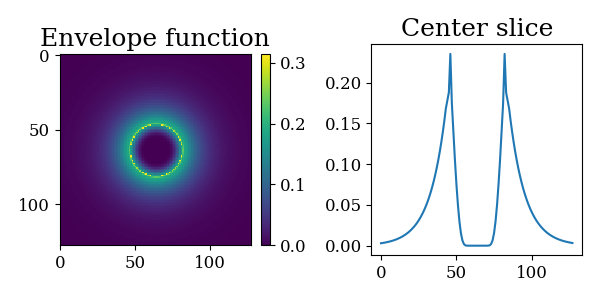

In [85]:
"""
Define a static ring envelope and duplicate it to generate a static movie
"""
envelope = pynoisy.RingEnvelope(inner_radius=0.135, photon_ring_thickness=0.025,
                                photon_ring_decay=200, inner_decay=12, ascent=.65)
noisy_movie = pynoisy.Movie()
noisy_movie.duplicate_single_frame(envelope.data, num_frames=100)

%matplotlib notebook
plot_envelope(envelope)


Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr
Producing clean visibilities from movie with nfft FT . . . 
Scattering Visibilities with Sgr A* kernel!


<IPython.core.display.Javascript object>


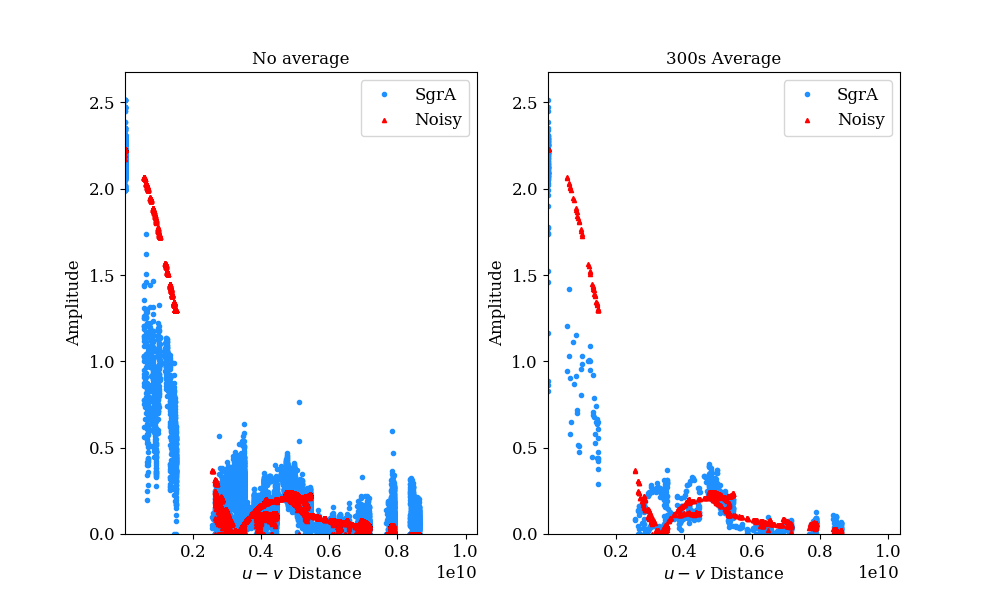

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


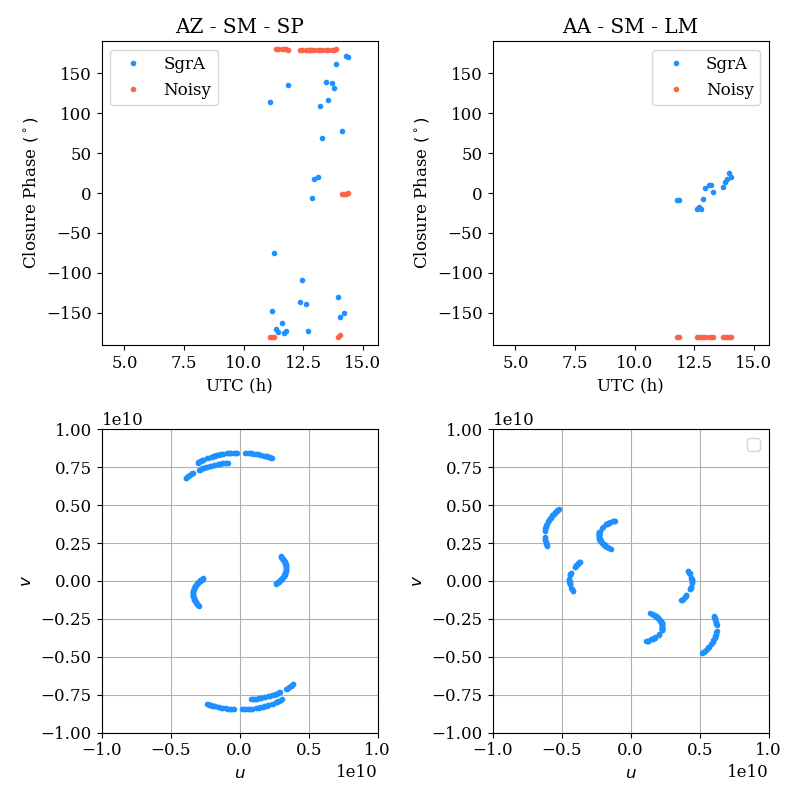

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Flagged 835/960 visibilities
Flagged 851/960 visibilities


In [86]:
"""
Generate a Movie object compare SgrA-like observations amplitudes
"""
movie = ehtim_movie(noisy_movie.frames, obs_sgra, total_flux=2.23, fov=125)
obs_noisy = movie.observe_same_nonoise(obs_sgra, sgrscat=True)

inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)
    
%matplotlib notebook
plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)

## Static Asymetric Ring

<IPython.core.display.Javascript object>


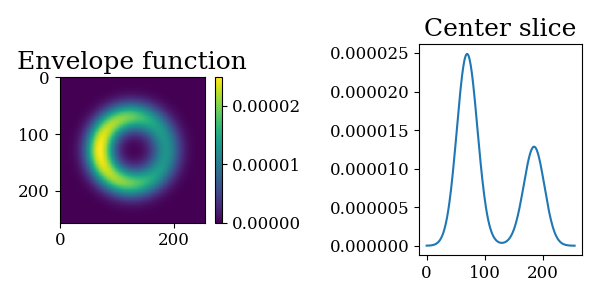

In [22]:
bright_spot_angle = np.deg2rad(0.0)
compact_zbl = 0.8
compact_zbl_frac=0.5
brightness_contrast = 0.5
radius = 29.5*eh.RADPERUAS
width = 20*eh.RADPERUAS
empty = eh.image.make_empty(npix=256, fov=125*eh.RADPERUAS, ra=12.51, dec=12.39, rf=230000000000.0, source='SgrA')
data = empty.add_ring_m1(compact_zbl_frac*compact_zbl, compact_zbl_frac*compact_zbl*brightness_contrast, radius, bright_spot_angle, width)
envelope = pynoisy.Envelope(data=data.imarr(), amplitude=0.01)

noisy_movie = pynoisy.Movie()
noisy_movie.duplicate_single_frame(envelope.data, num_frames=100)

%matplotlib notebook
plot_envelope(envelope)


Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr
Producing clean visibilities from movie with nfft FT . . . 
Scattering Visibilities with Sgr A* kernel!


<IPython.core.display.Javascript object>


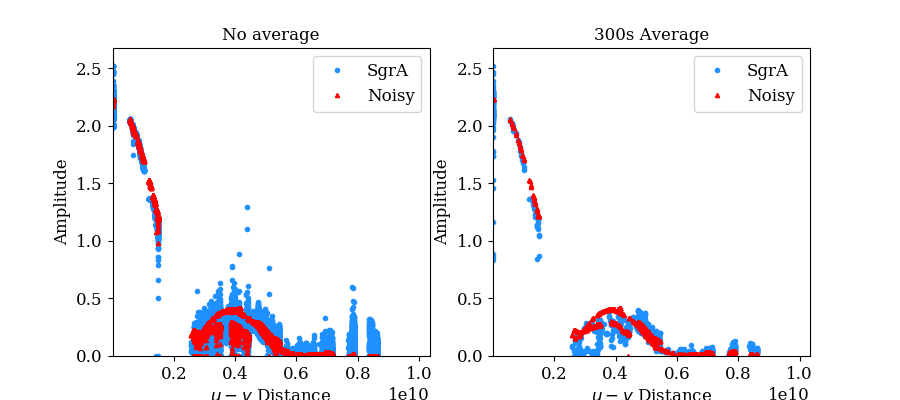

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


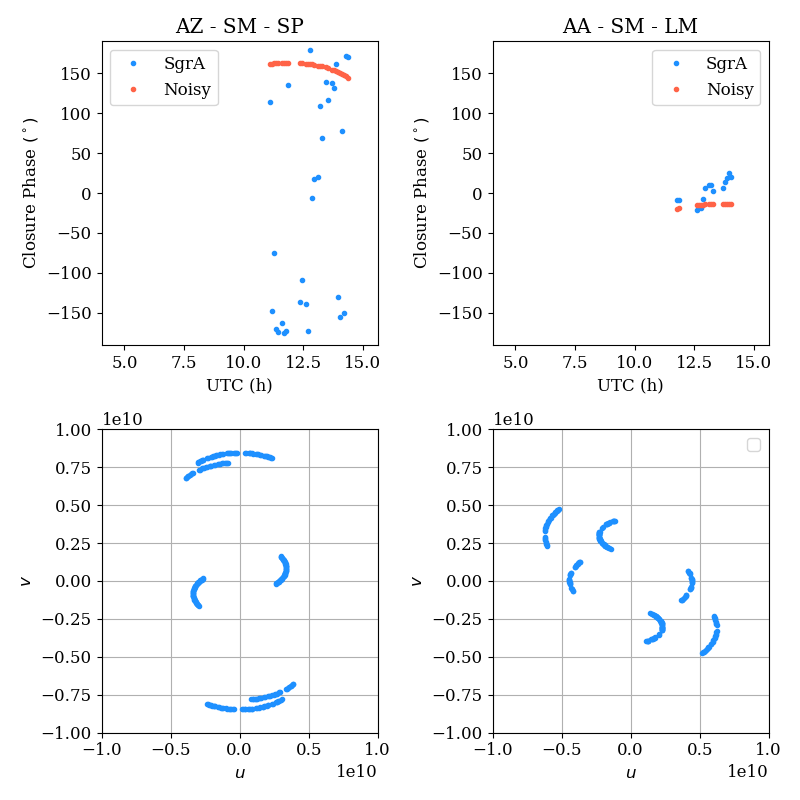

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Flagged 835/960 visibilities
Flagged 851/960 visibilities


In [23]:
movie = ehtim_movie(noisy_movie.frames, obs_sgra, total_flux=2.23, fov=125)
obs_noisy = movie.observe_same_nonoise(obs_sgra, sgrscat=True)

inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)
    
%matplotlib notebook
plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)

## Static Disk

<IPython.core.display.Javascript object>


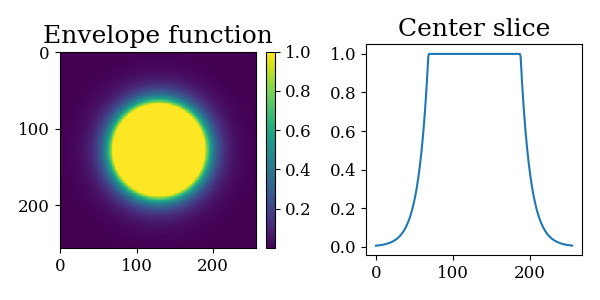

In [5]:
envelope = pynoisy.DiskEnvelope(radius=39.346734 / 160.0, decay=20)
noisy_movie = pynoisy.Movie()
noisy_movie.duplicate_single_frame(envelope.data, num_frames=100)
%matplotlib notebook
fig, ax = plt.subplots(1, 2, figsize=(6,3))
plt.sca(ax[0])
envelope.imshow()
plt.sca(ax[1])
plt.plot(envelope.data[128,:])
ax[1].set_title('Center slice', fontsize=18)
plt.tight_layout()


Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr
Producing clean visibilities from movie with nfft FT . . . 
Scattering Visibilities with Sgr A* kernel!


<IPython.core.display.Javascript object>


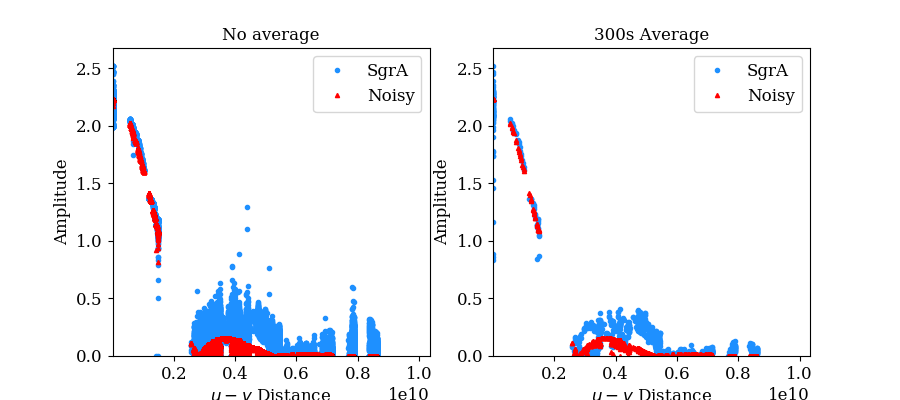

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


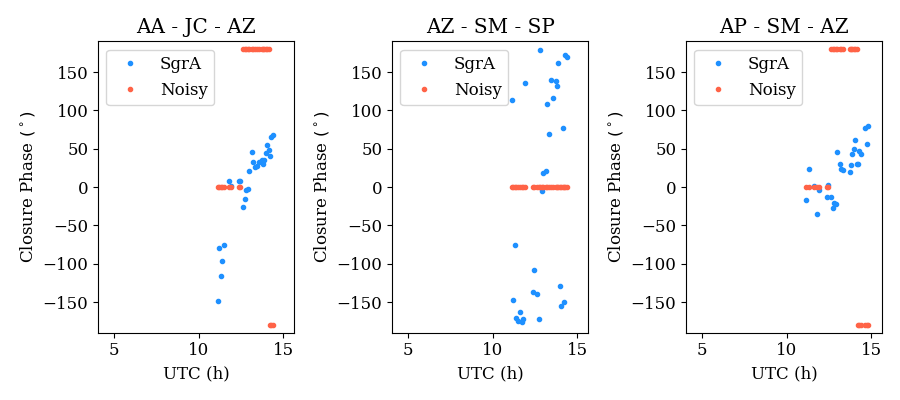

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


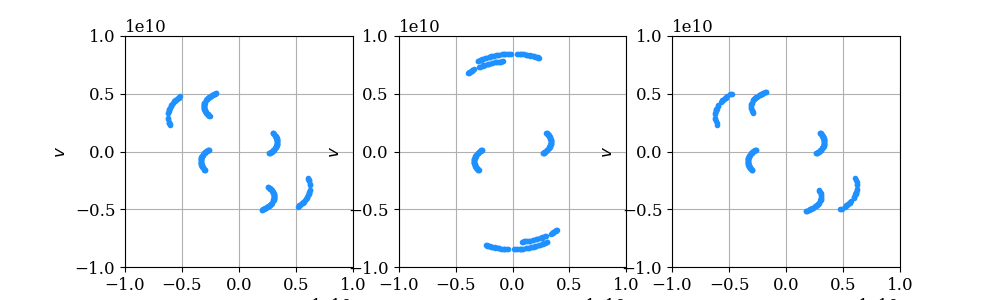

Flagged 839/960 visibilities
Flagged 835/960 visibilities
Flagged 855/960 visibilities


In [8]:
"""
Generate a Movie object compare SgrA-like observations amplitudes
"""
movie = ehtim_movie(noisy_movie.frames, obs_sgra, total_flux=2.23, fov=160)
obs_noisy = movie.observe_same_nonoise(obs_sgra, sgrscat=True)

inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)
    
%matplotlib notebook
plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)

## Convert Static Envelopes to uvfits

In [179]:
def select_path(i, paths):
    print(paths[i])
    return paths[i]

directory = os.path.join(
    ehtim_home, 'SgrA/synthetic_data_SGRA_3599_lo/dataset3.0/'
)
paths = glob.glob(directory + '*.fits')

file = interactive(select_path, i=(0, len(uv_paths)-1), paths=fixed(paths));
display(file)

interactive(children=(IntSlider(value=2, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

In [188]:
fits_to_uvfits(file.result)

Loading fits image:  /home/aviad/Code/eht-imaging/SgrA/synthetic_data_SGRA_3599_lo/dataset3.0/a/elliptical_disk_fiducial.fits
reading stokes images from top HDU -- assuming IQUV

Merging 100 frames from MJD 57850 3.97 hr to MJD 57850 15.60 hr
Warning!! assuming a constant frame duration, but Movie objects now support unequally spaced frames!
Producing clean visibilities from movie with direct FT . . . 
Applying Jones Matrices to data . . . 
Applying Jones Matrices to data . . . 
Warning!: in add_jones_and_noise, some SEFDs are <= 0!
Resorting to data point sigmas, which may add too much systematic noise!
   Applying gain corruption: ampcal-->False
   Applying atmospheric phase corruption: phasecal-->False
   Applying D Term mixing: dcal-->False
Adding thermal noise to data . . . 
Building NX table
No NX table in saved uvfits


## Dynamic Envelopes

In [189]:
def select_path(i, paths):
    print(paths[i])
    return paths[i]

directory = os.path.join(
    ehtim_home, 'SgrA/synthetic_data_SGRA_3599_lo/dataset3.0/'
)
uv_paths = glob.glob(directory + '*.uvfits')

uvfile = interactive(select_path, i=(0, len(uv_paths)-1), paths=fixed(uv_paths));
display(uvfile)

interactive(children=(IntSlider(value=4, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

In [196]:
obs_noisy = eh.obsdata.load_uvfits(uvfile.result)

Loading uvfits:  /home/aviad/Code/eht-imaging/SgrA/synthetic_data_SGRA_3599_lo/dataset3.0/a/dbsrc_fiducial.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


<IPython.core.display.Javascript object>


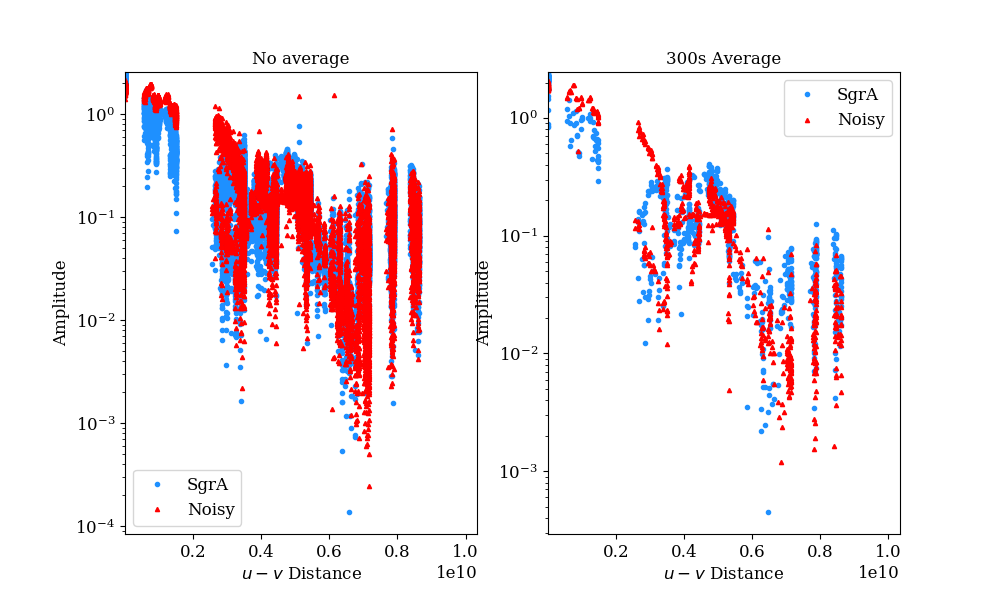

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


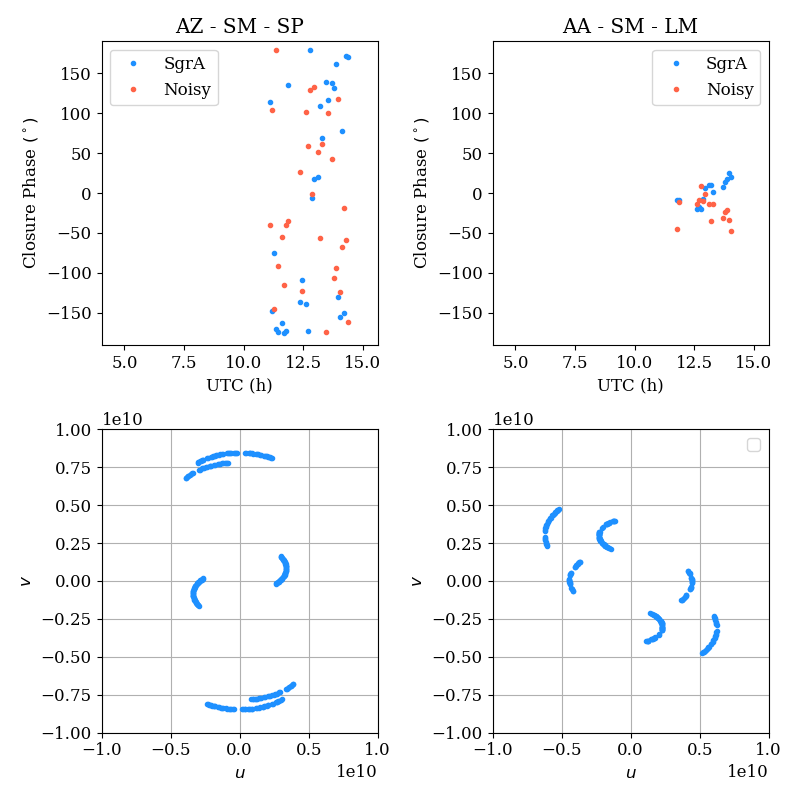

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Flagged 835/960 visibilities
Flagged 851/960 visibilities


In [197]:
inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)

%matplotlib notebook
plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime, logplot=True)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)